### NYC Arrests - Data Analysis

<hr>

This notebook extracts NYC arrest data from NYC OpenData. Data is then processed and exported to a CSV file which is then imported into Tableau for data visualization.

Before running this notebook, ensure you the following shape files:
<ul>
   <li>Neighborhood Tabluation Areas (NTA)</li>
   <li>Police Precincts</li> 
<ul>

<hr>

### Imports

In [18]:
#!/usr/bin/env python

# make sure to install necessary packages before running
# GeoPandas might be a bit difficult to install

import os
import datetime
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sodapy import Socrata

import geopandas
from shapely.geometry import Point

### Get data from NYC OpenData

In [32]:
# NYPD Arrest Data (Year to Date)
socrata_dataset_identifier_ny_data_ytd = 'uip8-fykc'

# NYPD Arrest Data (Historic)
socrata_dataset_identifier_ny_data_his = '8h9b-rp9u'
socrata_domain = 'data.cityofnewyork.us'

# read application token
with open('app-token.txt', 'r') as fp:
    contents = fp.read()
socrata_token = contents

# connect to data
client = Socrata(socrata_domain, socrata_token)

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata('data.cityofnewyork.us',
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# results = client.get(socrata_dataset_identifier, limit=1000)

# Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

#### Metadata associated with the data pull

In [20]:
# Metadata
metadata = client.get_metadata(socrata_dataset_identifier)
metadata_columns = [x['name'] for x in metadata['columns']]
# metadata_columns

In [21]:
# Metadata for a particular column
meta_arrest_col_date = [x for x in metadata['columns'] if x['name'] == 'ARREST_DATE'][0]
# meta_arrest_col

#### Get date range of the data and size of data

In [22]:
# get date range of data
# note: string is returned
most_recent_date = meta_arrest_col_date['cachedContents']['largest']
oldest_date = meta_arrest_col_date['cachedContents']['smallest']
num_of_results = int(meta_arrest_col_date['cachedContents']['not_null'])

print("Most recent date: " + most_recent_date)
print("Oldest date: " + oldest_date)
print("Total number of not null results: "+ str(num_of_results))

Most recent date: 2019-12-31T00:00:00.000
Oldest date: 2006-01-01T00:00:00.000
Total number of not null results: 4798339


### Get the data using the API

In [23]:
# Get data from 2019-01-01 to end of previous calendar year

# loop through the results (to prevent data from crashing)
loop_size = 10000

data = []
results = True
i = 0
while(results):
    results = client.get(socrata_dataset_identifier_ny_data_his, 
#                          where="ARREST_DATE BETWEEN '2019-01-01T00:00:00.000' AND '2019-12-31T00:00:00.000'",
                         where="ARREST_DATE >= '2019-01-01T00:00:00.000'",
                         # select="column1,column2,etc",
                         # order="column1 ASC",
                         # can also do other operations 
                         limit=loop_size,
                         offset=loop_size * i)
    i += 1
    data.extend(results)

In [33]:
# Get data from year to date

now = datetime.datetime.now()
current_year =  now.year

results = True
i = 0
while(results):
    results = client.get(socrata_dataset_identifier_ny_data_ytd, 
                         where= f"ARREST_DATE >= '{current_year}-01-01T00:00:00.000'",
                         limit=loop_size,
                         offset=loop_size * i)
    i += 1
    data.extend(results)

In [41]:
# put the data in a pandas dataframe
results_df = pd.DataFrame(data)

### Quick exploration of data

In [42]:
# What is law_cat_cd with value 'I'? Likely Traffic Infraction
results_df.loc[results_df['law_cat_cd'] == 'I'].head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
631,191775999,2019-01-02T00:00:00.000,997,UNCLASSIFIED,882,PARKING OFFENSES,VTL122000A,I,K,60,0,45-64,M,WHITE,986713,149102,40.57593439500005,-73.99113524499995
677,191739542,2019-01-02T00:00:00.000,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",881,OTHER TRAFFIC INFRACTION,VTL11110D1,I,K,68,0,25-44,M,WHITE HISPANIC,982911,168066,40.627986970000045,-74.00482527099996
1044,191775996,2019-01-02T00:00:00.000,997,UNCLASSIFIED,882,PARKING OFFENSES,VTL122000A,I,K,60,0,25-44,M,WHITE,986713,149102,40.57593439500005,-73.99113524499995
1868,191791350,2019-01-03T00:00:00.000,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",881,OTHER TRAFFIC INFRACTION,VTL037502A,I,K,76,0,45-64,M,BLACK,983863,185482,40.67579020100004,-74.00139663499994
2762,191886707,2019-01-04T00:00:00.000,969,"TRAFFIC,UNCLASSIFIED INFRACTIO",881,OTHER TRAFFIC INFRACTION,VTL0319003,I,S,121,3,18-24,F,BLACK,942825,166367,40.623226819000074,-74.14922697299994


In [43]:
# quick summary of data
results_df.describe()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
count,259441,259441,259398,259248,259248,259248,259441,257675,259441,259441,259441,259441,259441,259441,259441,259441,259441,259441
unique,259022,456,274,260,132,65,1184,4,5,77,25,5,2,7,32530,34523,41829,41829
top,201758771,2019-05-02T00:00:00.000,101,ASSAULT 3,344,ASSAULT 3 & RELATED OFFENSES,PL 1552500,M,K,40,0,25-44,M,BLACK,1046315,187088,40.67998073800004,-73.77623390699993
freq,2,888,29749,29749,31980,38846,25792,151637,70385,8539,227567,138544,212563,124561,2044,2047,2044,2044


### Clean data to make analysis easier

In [44]:
# change arrest_boro abbreviation to long form
boro_dict = {
    'B': 'Bronx',
    'S': 'Staten Island',
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens',
}
results_df['arrest_boro'] = results_df.arrest_boro.replace(boro_dict)

# change perp_sex abbreviation to long form
perp_sex_dict = {
    'F': 'Female',
    'M': 'Male',
}
results_df['perp_sex'] = results_df.perp_sex.replace(perp_sex_dict)

# change law_cat_cd abbreviation to long form
law_cat_cd_dict = {
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I': 'Traffic Infraction',
}
results_df['law_cat_cd'] = results_df['law_cat_cd'].replace(law_cat_cd_dict)

In [45]:
# change perp_race from all caps to title case
results_df['perp_race'] = results_df['perp_race'].apply(lambda x: x.title())

# change perp_race from all caps to title case
results_df['ofns_desc'] = results_df['ofns_desc'].astype(str)
results_df['ofns_desc'] = results_df['ofns_desc'].apply(lambda x: x.title())

AttributeError: 'float' object has no attribute 'title'

In [51]:
# change latitude and longitude from string to numeric
results_df['latitude'] = pd.to_numeric(results_df['latitude'])
results_df['longitude'] = pd.to_numeric(results_df['longitude'])
# print(results_df.dtypes)

### Prepare data for spatial analysis
##### Note: this step may take a long time

In [52]:
# add a column of the neighborhood name within NYC (for Tableau)

url = r"Data\Spatial Files\Neighborhood Tabulation Areas (NTA)\geo_export_0c82a76e-3045-414c-9b45-6c529ffc990f.shp"
gdf_locations = geopandas.read_file(url)

# convert to GeoDataFrame and create a column of shapely points
gdf = geopandas.GeoDataFrame(
    results_df, geometry=geopandas.points_from_xy(x=results_df.longitude, y=results_df.latitude)
)

def get_ntaname(shapely_point):
    """Returns the neighborhood name in NYC given a Shapely Point"""
    filter_ = gdf_locations['geometry'].contains(shapely_point)
    ntaname_pd_series = gdf_locations.loc[filter_, 'ntaname']
    if(len(ntaname_pd_series)==0):
        return "Unknown"
    else:
        ntaname = ntaname_pd_series.to_string(index=False).strip()
        return ntaname

# create a new column with the nyc neighborhood
# is there a faster way to do this? vectorize?
gdf['neighborhood'] = gdf['geometry'].map(get_ntaname)

In [53]:
# unknown neighborhoods
unknown_neighborhoods_df = gdf[gdf['neighborhood'] == "Unknown"]

print(unknown_neighborhoods_df.shape)
print()
print(unknown_neighborhoods_df)

(43, 20)

       arrest_key              arrest_date pd_cd  \
5040    192009567  2019-01-08T00:00:00.000   922   
6218    192150967  2019-01-10T00:00:00.000   922   
12297   192532849  2019-01-19T00:00:00.000   922   
25692   193361226  2019-02-09T00:00:00.000   905   
26590   193412812  2019-02-10T00:00:00.000   922   
32273   193773647  2019-02-20T00:00:00.000   905   
34501   193884698  2019-02-23T00:00:00.000   905   
36424   194047983  2019-02-27T00:00:00.000   922   
41218   194362388  2019-03-06T00:00:00.000   567   
41266   194362390  2019-03-06T00:00:00.000   567   
41725   194410530  2019-03-07T00:00:00.000   922   
43777   194516515  2019-03-10T00:00:00.000   922   
46207   194709761  2019-03-14T00:00:00.000   707   
58119   195478863  2019-04-02T00:00:00.000   922   
68733   196134767  2019-04-17T00:00:00.000   922   
76364   196593732  2019-04-30T00:00:00.000   922   
83711   197060871  2019-05-11T00:00:00.000   905   
95826   197886282  2019-05-31T00:00:00.000   109   
96

In [54]:
results_df.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry,neighborhood
0,191706686,2019-01-01T00:00:00.000,259,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",351,Criminal Mischief & Related Of,PL 1450001,Misdemeanor,Manhattan,18,0,25-44,Male,White,986665,217198,40.762843,-73.991284,POINT (-73.99128 40.76284),Clinton
1,191719220,2019-01-01T00:00:00.000,439,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",109,Grand Larceny,PL 1553004,Felony,Staten Island,120,0,<18,Male,White Hispanic,962822,174282,40.645023,-74.077217,POINT (-74.07722 40.64502),West New Brighton-New Brighton-St. George
2,191719210,2019-01-01T00:00:00.000,759,"PUBLIC ADMINISTATION,UNCLASS M",359,Offenses Against Public Admini,PL 1950500,Misdemeanor,Brooklyn,77,0,25-44,Male,Black,1001066,185066,40.674632,-73.939378,POINT (-73.93938 40.67463),Crown Heights North
3,191717225,2019-01-01T00:00:00.000,922,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348,Vehicle And Traffic Laws,VTL0511001,Misdemeanor,Queens,113,0,25-44,Male,Black Hispanic,1049768,184837,40.673777,-73.763806,POINT (-73.76381 40.67378),Springfield Gardens North
4,191717212,2019-01-01T00:00:00.000,244,"BURGLARY,UNCLASSIFIED,UNKNOWN",107,Burglary,PL 1402000,Felony,Manhattan,19,0,25-44,Male,Black,994297,218680,40.766905,-73.963731,POINT (-73.96373 40.76691),Upper East Side-Carnegie Hill


### Summary of data and some data visualization

In [55]:
# unique arrest_boro
print(results_df.arrest_boro.unique())

# unique perp_sex
print()
print(results_df.perp_sex.unique())

# unique perp_race
print()
print(results_df.perp_race.unique())

# unique perp_race
print()
print(results_df['law_cat_cd'].value_counts(dropna=False))

# unique pd_desc
print()
unique_pd_desc = results_df.pd_desc.unique()
print(len(unique_pd_desc))

print()
print(results_df['arrest_boro'].value_counts(dropna=False))

print()
print(results_df['jurisdiction_code'].value_counts(dropna=False))


print()
print(results_df['neighborhood'].value_counts(dropna=False))

print()
print(results_df.shape)

print()
print(results_df.dtypes)

['Manhattan' 'Staten Island' 'Brooklyn' 'Queens' 'Bronx']

['Male' 'Female']

['White' 'White Hispanic' 'Black' 'Black Hispanic'
 'American Indian/Alaskan Native' 'Asian / Pacific Islander' 'Unknown']

Misdemeanor           151637
Felony                102408
Violation               3139
NaN                     1766
Traffic Infraction       491
Name: law_cat_cd, dtype: int64

261

Brooklyn         70385
Manhattan        65341
Bronx            58864
Queens           53868
Staten Island    10983
Name: arrest_boro, dtype: int64

0     227567
1      10301
2       9492
97      4152
3       3518
72       925
6        673
4        637
11       514
73       407
15       282
71       233
14       215
7        187
87        66
9         63
85        50
16        44
13        36
88        34
12        28
69         9
79         5
76         2
74         1
Name: jurisdiction_code, dtype: int64

Midtown-Midtown South                         5841
East New York                                 5774
Ea

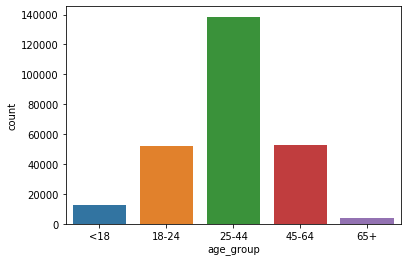

In [56]:
def order_labels(age_group_labels):
    """Returns age_group label sorted in ascending order"""
    ordered_labels = sorted(list(age_group_labels))
    last_item = ordered_labels.pop()
    ordered_labels.insert(0, last_item)
    return ordered_labels
    
age_group_labels = order_labels(results_df.age_group.unique())

sns.countplot(results_df['age_group'], order=age_group_labels)

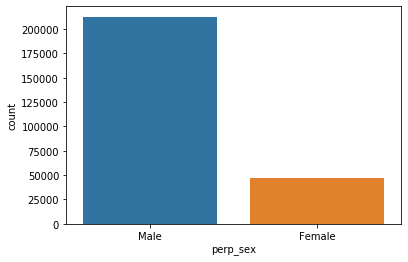

In [57]:
sns.countplot(results_df['perp_sex'], )

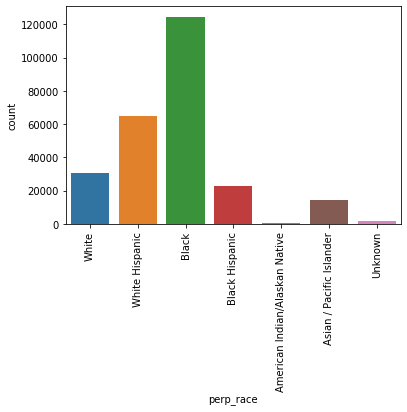

In [58]:
plot_race = sns.countplot(results_df['perp_race'], )
tick_labels = plot_race.get_xticklabels()
plot_race = plot_race.set_xticklabels(tick_labels, rotation=90)

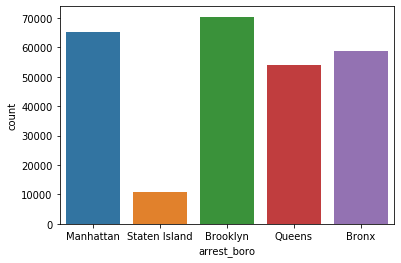

In [59]:
sns.countplot(results_df['arrest_boro'], )

In [60]:
# export Pandas DataFrame to csv
today = datetime.date.today()
results_df.to_csv(f"{today}_nypd-arrests.csv", index_label="unique_id")